# Enquête emploi en continu 2015

---
## Experimental Setup

### Libraries & Settings

In [1]:
import os              # General OS commands
import numpy as np     # NumPy
import pandas as pd    # Python Data Analysis Library
import zipfile         # Compress/decompress ZIP files
import sqlite3         # SQLite3 Database Driver
import re              # Regular Expressions

In [2]:
import statsmodels.api as sm
from sklearn import linear_model, metrics
import math

In [3]:
# Never truncate columns, display all the data
from IPython.display import display, HTML
pd.set_option('display.max_colwidth', -1)

# Display floating-point numbers with 4 decimals in `pandas.DataFrame`
pd.options.display.float_format = '{:,.4f}'.format

# Ordered dictionaries remember the order that items were inserted
from collections import OrderedDict

# matplotlib
import matplotlib.pyplot as plt
# Display MatPlotLib stuff inline
%matplotlib inline

### Database

In [4]:
zip_filename = "../data/ee-insee-2015_custom-sqlite.zip"
eedb = zip_filename.replace("-sqlite.zip", ".sqlite")

if not os.path.exists(eedb):
    with zipfile.ZipFile(zip_filename) as zip_file:
        zip_file.extractall("../data/")

In [5]:
with sqlite3.connect(eedb) as con:
    query = "SELECT * FROM eec15_custom"
    eec15 = pd.read_sql_query(query, con)

In [6]:
# Create a ("female" x "enfant") interaction variable
bool_ = eec15[["enfants_", "female_"]].astype(bool)
eec15["female_enfants_"] = (bool_.enfants_ & bool_.female_).astype(int)

# Drop data we don't need
eec15 = eec15[eec15.age60_ == 0]
eec15 = eec15.drop("age60_", 1)

### Parameters

In [7]:
# Build a list of parameters to include in the model, using regex
# https://www.datarobot.com/blog/multiple-regression-using-statsmodels/
filters = {
    "age": "^age[0-9]{2}_$",
    "diploma": "^dip[0-9]{2}_$",
    "etranger": "^etranger_$",
    "domtom": "^domtom_$",
#     "trim": "^trim$",
    "female": "^female_$",
    "enfants": "^enfants_$",
#     "female_enfants": "^female_enfants_$",
    "region": "^region[1-2]_$"
}
params = {k: sorted([x for x in eec15.columns if re.match(r, x)]) for (k, r) in filters.items()}

# Avoid the dummy variable trap
params = {k: (v if len(v) == 1 else v[:-1]) for (k, v) in params.items()}
params["region"] += ["region2_"]

In [8]:
trims = ["t{}".format(x) for x in sorted(eec15["trim"].unique())]
eec15_ = {t: eec15[eec15.trim == int(t[1])] for t in trims}
X = {t: eec15_[t][sum(params.values(), [])] for t in eec15_}
y = {t: eec15_[t]["actop_"] for t in eec15_}

### Data

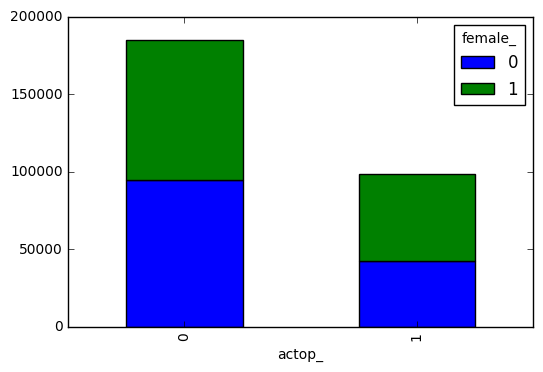

In [9]:
pd.crosstab(eec15.actop_, eec15.female_).plot(kind='bar', stacked=True)

In [10]:
print "Probability of employment:", eec15["actop_"].mean()

Probability of employment: 0.347426515966


---
## Fitting the model

### Train the model using `trim=1` data

In [11]:
models = OrderedDict({
    "linear_sk": linear_model.LinearRegression(fit_intercept=True).fit(X["t1"], y["t1"]),
    "linear_sm": sm.OLS(y["t1"], sm.add_constant(X["t1"])).fit(disp=False),
    
    "logit_sk": linear_model.LogisticRegression(solver="sag").fit(X["t1"], y["t1"]),
    "logit_sm": sm.Logit(y["t1"], sm.add_constant(X["t1"])).fit(disp=False),

#     "probit_sk": no `probit` in sci-kit learn
    "probit_sm": sm.Probit(y["t1"], sm.add_constant(X["t1"])).fit(disp=False),  
})

In [12]:
# These functions allow us to enable/disable models throughout the notebook
# by simply commenting them out in the dictionary above
def enabled(models_list):
    if not isinstance(models_list, list):
        raise Exception("Argument to 'enabled()' should be a list.")
    return all([m in models for m in models_list])

def enabled_models(models_list):
    return [x for x in models_list if x in models]

def model_type(model):
    return model[:-3]

In [13]:
# Display summary for models that have one
for m in enabled_models(["linear_sm", "logit_sm", "probit_sm"]):
    # display(models[m].summary)        # HTML
    print models[m].summary(); print    # raw

                            OLS Regression Results                            
Dep. Variable:                 actop_   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     1400.
Date:                Tue, 28 Feb 2017   Prob (F-statistic):               0.00
Time:                        23:13:50   Log-Likelihood:                -38183.
No. Observations:               72838   AIC:                         7.641e+04
Df Residuals:                   72818   BIC:                         7.659e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.3677      0.007     52.357      0.0

In [14]:
# Compare the coefficients from both fits (they should be the same)
regressors = list(X["t1"].columns) + ["const"]
coeffs = {}

if enabled(["linear_sm", "linear_sk"]):
    coeffs["linear"] = pd.DataFrame(index=regressors)
    coeffs["linear"]["sm"] = models["linear_sm"].params
    coeffs["linear"]["sk"] = pd.Series(np.append(models["linear_sk"].coef_, models["linear_sk"].intercept_), index=regressors)
    coeffs["linear"]["diff"] = coeffs["linear"]["sm"] - coeffs["linear"]["sk"]
    
if enabled(["logit_sm", "logit_sk"]):
    coeffs["logit"] = pd.DataFrame(index=regressors)
    coeffs["logit"]["sm"] = models["logit_sm"].params
    coeffs["logit"]["sk"] = pd.Series(np.append(models["logit_sk"].coef_, models["logit_sk"].intercept_), index=regressors)
    coeffs["logit"]["diff"] = coeffs["logit"]["sm"] - coeffs["logit"]["sk"]
    
for mtype in coeffs:
    print mtype
    display(coeffs[mtype].sort_index().transpose())

logit


,age15_,age30_,age40_,const,dip10_,dip11_,dip30_,dip31_,dip33_,dip41_,dip42_,dip50_,dip60_,dip70_,domtom_,enfants_,etranger_,female_,region1_,region2_
sm,1.5972,0.3117,-0.0758,-0.6978,-1.9053,-2.3686,-1.0517,-1.8161,-2.1377,-0.5214,-1.3976,-0.9673,0.1498,-0.1829,0.6042,-0.4556,0.6915,0.5176,0.2039,0.2614
sk,1.5949,0.3096,-0.0766,-0.7008,-1.8975,-2.3516,-1.0374,-1.8079,-2.1187,-0.5149,-1.3906,-0.9618,0.1555,-0.1775,0.6052,-0.4552,0.6925,0.5166,0.2030,0.2608
diff,0.0023,0.0022,0.0008,0.0031,-0.0078,-0.0171,-0.0143,-0.0082,-0.0190,-0.0065,-0.0070,-0.0055,-0.0057,-0.0054,-0.0010,-0.0003,-0.0010,0.0009,0.0009,0.0006


linear


,age15_,age30_,age40_,const,dip10_,dip11_,dip30_,dip31_,dip33_,dip41_,dip42_,dip50_,dip60_,dip70_,domtom_,enfants_,etranger_,female_,region1_,region2_
sm,0.3206,0.0495,-0.0073,0.3677,-0.3453,-0.3799,-0.2223,-0.3302,-0.3673,-0.0953,-0.2746,-0.2058,0.0370,-0.0465,0.1124,-0.0717,0.1289,0.0841,0.0348,0.0448
sk,0.3206,0.0495,-0.0073,0.3677,-0.3453,-0.3799,-0.2223,-0.3302,-0.3673,-0.0953,-0.2746,-0.2058,0.0370,-0.0465,0.1124,-0.0717,0.1289,0.0841,0.0348,0.0448
diff,-0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000


### Apply the model to test data (`trim=2/3/4`)

In [15]:
# Check the accuracy of the model on the training & test sets
accuracy = pd.DataFrame(index=trims)

# To avoid the pitfall from the above calculation, we need to map [0, 1] -> {0, 1}
# We define a threshold probability above which we consider an individual to be employed
THRESHOLD = 0.5

if enabled(["linear_sk"]):
    accuracy["linear_sk"] = pd.Series()
    for t in trims:
        predicted = models["linear_sk"].predict(X[t])
        predicted = np.where(predicted < THRESHOLD, 0, 1)
        accuracy["linear_sk"][t] = metrics.accuracy_score(y[t], predicted)

for m in enabled_models(["logit_sm", "probit_sm"]):
    accuracy[m] = pd.Series()
    for t in trims:
        # Note: the three methods for computing `predicted` are equivalent
        # predicted = np.where(models[m].predict_proba(X[t]).T[1] < THRESHOLD, 0, 1)
        # predicted = models[m].predict(X[t])    # THRESHOLD = 0.5 is implied
        predicted = np.where(models[m].predict(sm.add_constant(X[t])) < THRESHOLD, 0, 1)
        accuracy[m][t] = metrics.accuracy_score(y[t], predicted)

accuracy

,linear_sk,logit_sm,probit_sm
t1,0.7626,0.7624,0.7617
t2,0.7681,0.7675,0.7668
t3,0.7606,0.7600,0.7594
t4,0.7636,0.7635,0.7629


---
## Marginal Effects

In [16]:
marginal_effects = pd.DataFrame()

### Analytically (using the derivative formula)
#### Logit
Recall that:
$$EM(x_1) = \frac{\partial{\mathbb{E}[y|x]}}{\partial{x_1}} = \beta_1 \Lambda'(\beta_0 + \beta_1 x_1 + ... )$$
where
$$\Lambda(x^T\beta) = \frac{e^{x^T\beta}}{1+e^{x^T\beta}} = P(y=1|x) = \mathbb{E}[y|x]$$
and
$$\Lambda'(x) = \frac{e^x}{(1+e^x)^2} = \Lambda(x)\Lambda(1-x) = \Lambda(x)\Lambda(-x)$$

#### Probit
Recall that:
$$EM(x_1) = \frac{\partial{\mathbb{E}[y|x]}}{\partial{x_1}} = \beta_1 \Phi'(\beta_0 + \beta_1 x_1 + ... ) = \beta_1 \phi(\beta_0 + \beta_1 x_1 + ... )$$
where
$$\Phi(x^T\beta) = P(y=1|x) = \mathbb{E}[y|x]$$
is the *cumulative distribution function* and
$$\Phi'(x) = \phi(x) = \frac{1}{\sqrt{2\pi}}\, e^{-\frac{x^2}{2}}$$
the *probability density function* of a **standard** normal distribution ($\mu = 0, \sigma = 1$)

**Note**: for each parameter, we calculate the *mean* marginal effect over the entire training dataset

In [22]:
if enabled(["logit_sm"]) or enabled(["logit_sk"]):
    def link(x):
        return math.exp(x)/(1+math.exp(x))

    def dlink(x):
        return link(x)*link(-x)
    
    y_fitted = X["t1"].dot(coeffs["logit"]["sm"][:-1])
    y_fitted += coeffs["logit"]["sm"]["const"]
    dlambda_y = y_fitted.map(dlambda)
    
    marginal_effects["analytical"] = coeffs["logit"]["sm"]*dlambda_y.mean()

### By "rule-of-thumb"
Note (from above) that:
$$EM(x_1) = \beta_1 \Lambda'(\beta_0 + \beta_1 x_1 + ... )$$
and 
$$\max \Lambda'(x) = \Lambda'(0) = \max \frac{e^0}{(1+e^0)^2} = \frac{1}{4}$$
Therefore, we have that:
$$EM(x_1) \approx \frac{\beta_1}{4}$$

The "rule-of-thumb" thus divides all regression coefficients by 4 to approximate the marginal effect.

In [23]:
marginal_effects["rule_of_thumb"] = coeffs["logit"]["sm"]/4

### By modifying the dataset ("passage de tout le monde en licence")

In [ ]:
brute_force = pd.Series()
for category in filters:
    for pivot in params[category]:
        non_pivots = [x for x in params[category] if x != pivot]
        
        X_one = X["t1"].copy() 
        X_one[non_pivots] = 0
        X_one[pivot] = 1

#         proba_one = reg_logit_sk.predict_proba(X_one).T[1].mean()
#         proba_t1 = reg_logit_sk.predict_proba(X["t1"]).T[1].mean()
        proba_one = reg_logit_sm.predict(sm.add_constant(X_one, has_constant="add")).mean()
        proba_t1 = reg_logit_sm.predict(sm.add_constant(X["t1"])).mean()
        brute_force[pivot] = proba_one - proba_t1

In [25]:
# marginal_effects["brute_force"] = brute_force
marginal_effects.transpose()

,etranger_,age15_,age30_,age40_,dip10_,dip11_,dip30_,dip31_,dip33_,dip41_,dip42_,dip50_,dip60_,dip70_,female_,enfants_,region1_,region2_,domtom_,const
analytical,0.1148,0.2652,0.0518,-0.0126,-0.3164,-0.3934,-0.1747,-0.3016,-0.3550,-0.0866,-0.2321,-0.1606,0.0249,-0.0304,0.0860,-0.0757,0.0339,0.0434,0.1003,-0.1159
rule_of_thumb,0.1729,0.3993,0.0779,-0.0190,-0.4763,-0.5922,-0.2629,-0.4540,-0.5344,-0.1303,-0.3494,-0.2418,0.0374,-0.0457,0.1294,-0.1139,0.0510,0.0653,0.1510,-0.1744


In [ ]:
ratios = marginal_effects.copy()
ratios = ratios.div(ratios["analytical"], axis=0)
ratios.transpose()